In [2]:
import os
import json
import pickle
import random
import copy
from PIL import Image, ImageDraw
import numpy as np
import torch

import matplotlib.pyplot as plt

os.environ["WANDB_DISABLED"] = "true"

In [3]:
# import nltk
# try:
#     nltk.data.find("tokenizers/punkt")
# except (LookupError, OSError):
#     nltk.download("punkt", quiet=True)

In [4]:
# uses common functions and not the ones declared in the beginning
# TODO: use only functions from library (vit_captioning_analysis) to avoid confusion
from vit_captioning_analysis import VITCaptioningModel
from vit_captioning_analysis import order_obj_instances

model = VITCaptioningModel(output_encoder_attentions=True, output_encoder_hidden_states=True)

model running on cuda


/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
# model.model.encoder

## Sanity check

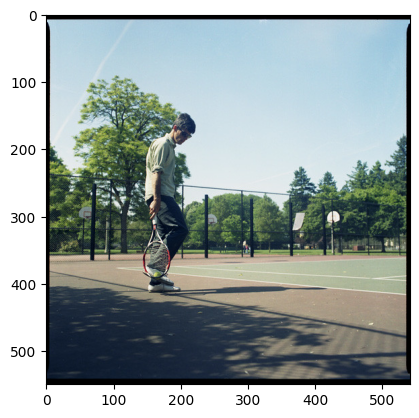

In [4]:
sample_image = Image.open('./526736409_b5dff13989_z.jpg').convert(mode="RGB")
plt.imshow(sample_image)

In [8]:
outputs = model.forward_pass([sample_image])

In [9]:
outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions'])

In [10]:
len(outputs.encoder_attentions)

12

In [11]:
outputs.encoder_attentions[0].shape

torch.Size([1, 12, 197, 197])

In [36]:
type(outputs.encoder_last_hidden_state)

torch.Tensor

In [37]:
outputs.encoder_last_hidden_state.shape

torch.Size([2, 197, 768])

In [38]:
type(outputs.encoder_hidden_states)

tuple

In [25]:
torch.stack(outputs.encoder_hidden_states).shape

torch.Size([13, 1, 197, 768])

In [10]:
len(outputs.encoder_hidden_states)

13

In [11]:
outputs.encoder_hidden_states[0].shape

torch.Size([1, 197, 768])

### Segmentation selection

From the filtered dataset, figure out which **instance** of the object will be used to create the object mask and select tokens.

This is required since objects have 1:N instances and some of them can be considered *background*, therefore tokens from these areas should not be considered.

**Options:**
* Object 1: 
    * biggest object in MAIN class
    * merge all masks of MAIN class into one
    * attention map based
* Object 2 
    * biggest object in SECONDARY class
    * merge all masks of SECONDARY class into one
    * closest mask to MAIN object
    * attention based
* ...

In [6]:
COCO_PATH = "../../../datasets/coco"

In [5]:
with open("../task1_person_accessory_data.json", "r") as f:
    person_annotations = json.load(f)
    
with open("../task2_dining_objects_data.json", "r") as f:
    dining_obj_annotations = json.load(f)    

In [7]:
with open("../task1_person_accessory_data_w_caption.json", "r") as f:
    person_annotations = json.load(f)    

In [8]:
with open('../coco_category_id_map.pickle', 'rb') as handle:
    category_id_map = pickle.load(handle) 

In [9]:
person_annotations.keys()

dict_keys(['27', '28', '31', '32', '33'])

In [9]:
dining_obj_annotations.keys()

dict_keys(['44', '47', '48', '49', '51', '62'])

In [10]:

# TODO: 
# * get secondary object based on proximity - closest object
# * limit objects closer to the main cluster of activation
#   or choose the main object from area in main cluster of activation 
def get_bbox_center(annotation):
     return np.array((annotation["bbox"][0] + int(annotation["bbox"][2]/2), 
             annotation["bbox"][1] + int(annotation["bbox"][3]/2)))

def get_largest_mask(annotation, obj, img_draw):
    # select main (largest) mask for the object class        
    objects_area = [(ann['id'], ann['area']) for ann in annotation['annotations']['annotations'] if ann['category_id']==obj and ann['iscrowd']==0]
    largest_obj = sorted(objects_area, key=lambda x: x[1], reverse=True)[0]
    largest_obj_ann = [ann for ann in annotation['annotations']['annotations'] if ann['id']==largest_obj[0]]
    largest_obj_ann = largest_obj_ann[0] #avoid more than one object with same area
    segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['id']==largest_obj_ann["id"]]
    for segment in segmentation[0]:
        try:
            img_draw.polygon(segment, fill ="#ffffff")
        except ValueError:
            return None
    return [largest_obj_ann]
    
def get_all_masks(annotation, obj, img_draw):
    segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
    for segment in segmentation:
        if isinstance(segment, list):
            try:
                img_draw.polygon(segment[0], fill ="#ffffff")
            except ValueError:
                return None
    return None

def get_mask_with_attention(img, annotation, category_id, img_draw, layer_attention_maps):
    segm_with_att = order_obj_instances(img, category_id, annotation, layer_attention_maps)
    for segment in segm_with_att[0][0]['segmentation']:
        img_draw.polygon(segment, fill ="#ffffff")
    return segm_with_att[0]

def get_objects_mask(annotation, objects=[], option=1, attention_maps=None):
    sample_image = Image.open(os.path.join(COCO_PATH, 'train2017', annotation['image']['file_name'])).convert('RGB')    
    masks = []
    for idx, obj in enumerate(objects):
        pil_mask = np.zeros(shape=sample_image.size, dtype=np.uint8)
        pil_mask = Image.fromarray(np.moveaxis(pil_mask, 0, -1))
        img_draw = ImageDraw.Draw(pil_mask) 
        
        if option == 1:
            get_largest_mask(annotation, obj, img_draw)

        # merge all masks of the object class into one
        elif option == 2:
            get_all_masks(annotation, obj, img_draw)    
                    
        # get closest mask based on a reference mask (first object)
        # calculate the centroid and then find the other mask closest to this centroid
        # using euclidian distance
        elif option == 3:
            ## assume first object is the reference. Get the first object based on biggest mask
            if idx==0:
                ref_annotation = get_largest_mask(annotation, obj, img_draw)[0]
            else:
                ref_center = get_bbox_center(ref_annotation)
                distances = [(np.linalg.norm(ref_center - get_bbox_center(ann)), ann["id"]) for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
                closest_obj = distances[0]
                segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['id']==closest_obj[1]]
                for segment in segmentation[0]:
                    try:
                        img_draw.polygon(segment, fill ="#ffffff")
                    except ValueError:
                        return None
        
        elif option == 4:
            # this option produces 12 masks, one for each layer of the transformers encoder
            pil_mask = []
            for layer in range(12):
                att_layer_mask = np.zeros(shape=sample_image.size, dtype=np.uint8)
                att_layer_mask = Image.fromarray(np.moveaxis(att_layer_mask, 0, -1))
                img_draw = ImageDraw.Draw(att_layer_mask) 
                get_mask_with_attention(sample_image, 
                                        annotation, 
                                        obj, 
                                        img_draw, 
                                        attention_maps[layer][0, 1:])
                pil_mask.append(att_layer_mask)
        
        masks.append(pil_mask)        
        
    return masks

In [11]:
## 

## Test different strategies for selecting segmentation 
Which instance of the object to choose:
1. Biggest segmentation mask
2. Merge all segmentation masks into one (joint segmentation mask)
3. Closest mask based on a reference mask (first object)
4. Attention based (instance that gets **maximum attention**)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/braian/anaconda3/envs/thesis-pytorch/lib/python3.9/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


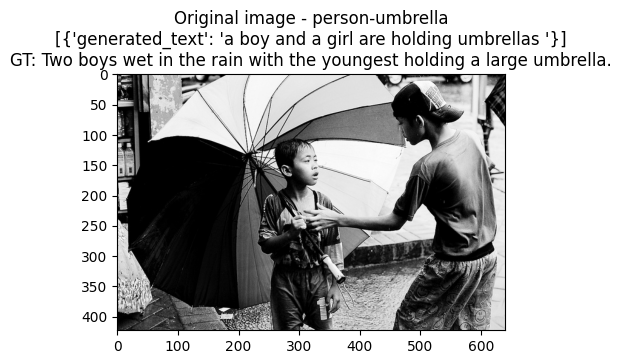

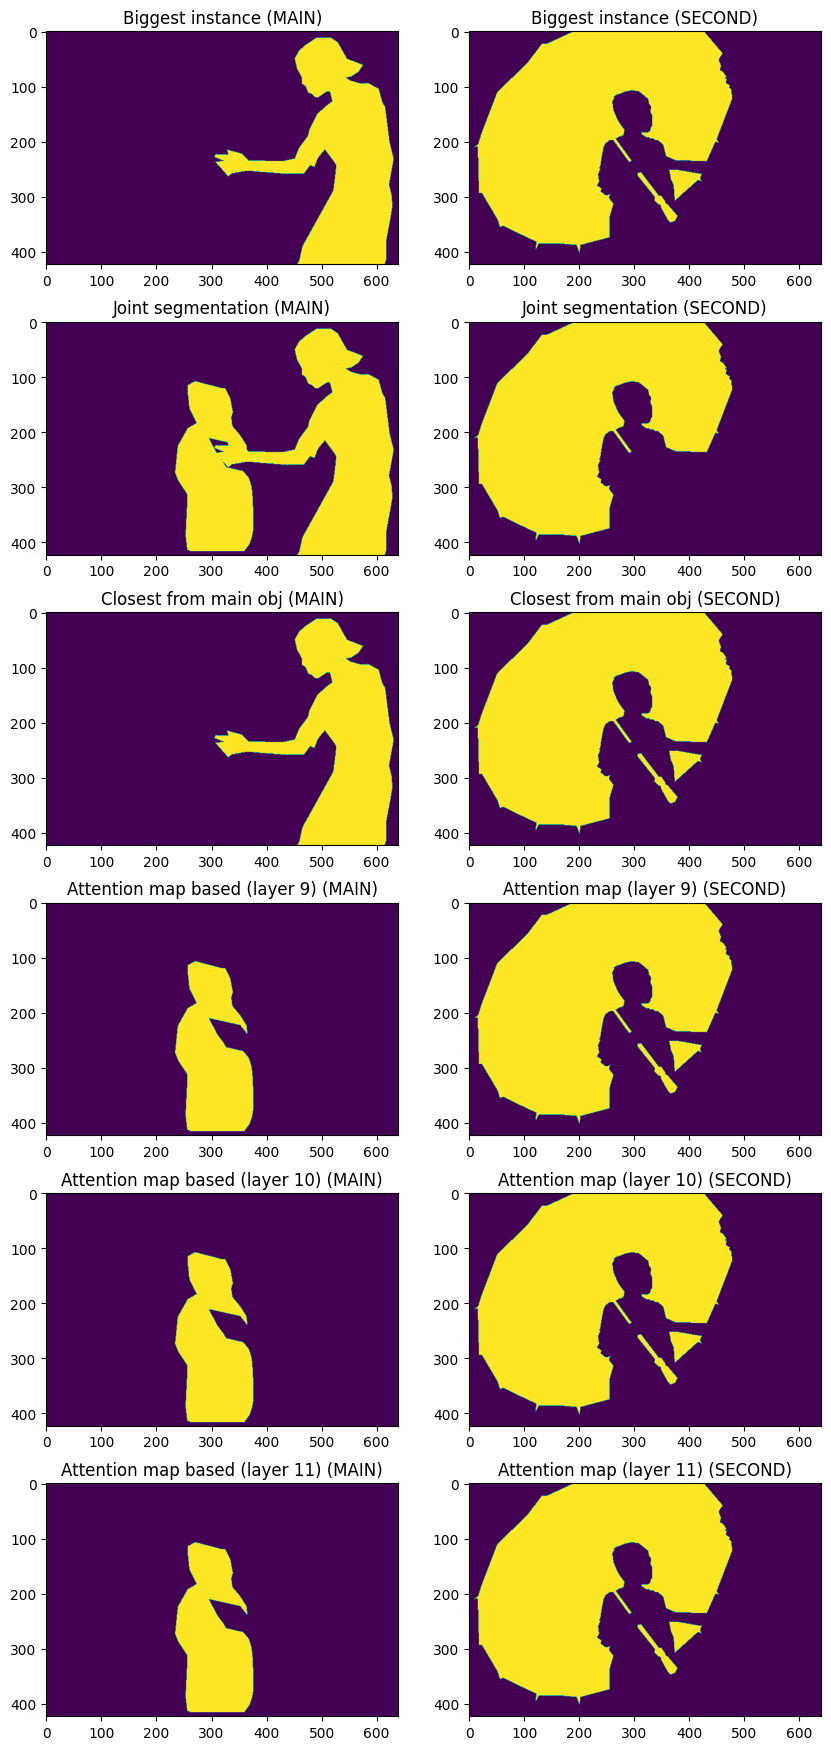

In [17]:
main_obj = 1
second_obj = 28

sample_ann = person_annotations[str(second_obj)][6]
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    

sample_caption = model.generate_caption([sample_img])[0]

plt.figure(figsize=(5,6))
plt.title(f"Original image - {category_id_map[main_obj]}-{category_id_map[second_obj]}\n{sample_caption}\nGT: {sample_ann['annotations']['caption']}")
plt.imshow(sample_img)
plt.show()

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(10, 22))
    
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=1)
axs[0, 0].set_title("Biggest instance (MAIN)")
axs[0, 0].imshow(masks[0])
axs[0, 1].set_title("Biggest instance (SECOND)")
axs[0, 1].imshow(masks[1])

masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=2)
axs[1, 0].set_title("Joint segmentation (MAIN)")
axs[1, 0].imshow(masks[0])
axs[1, 1].set_title("Joint segmentation (SECOND)")
axs[1, 1].imshow(masks[1])
    
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=3)
axs[2, 0].set_title("Closest from main obj (MAIN)")
axs[2, 0].imshow(masks[0])
axs[2, 1].set_title("Closest from main obj (SECOND)")
axs[2, 1].imshow(masks[1])

outputs = model.forward_pass([sample_img])
# [Layer, Batch, Heads, Patch, Patch]
sample_attention_map = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions)).cpu().detach().numpy()[:,0,:,:]
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=4, attention_maps=sample_attention_map)
axs_idx = 3
for layer in range(9, 12):
    axs[axs_idx, 0].set_title(f"Attention map based (layer {layer}) (MAIN)")
    axs[axs_idx, 0].imshow(masks[0][layer])
    axs[axs_idx, 1].set_title(f"Attention map (layer {layer}) (SECOND)")
    axs[axs_idx, 1].imshow(masks[1][layer])
    axs_idx += 1

### Questions:
1. in the example above, does selecting a different boy yields the same results?
2. Both "person" object can be decoded as person?

# Relevant token extraction

In [12]:
#grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
grid_size = 14

In [13]:
from vit_captioning_analysis import is_patch_within_mask, find_original_img_patch

### Get tokens:
1. Maximum and minimum attention token in the region for object 1. 
2. Maximum and minimum attention token from object 2. 
3. A Random token each from both objects. 
4. Max token from the whole image
5. The token consistently paid attention in last 3 layers. (from the whole image? or just FG?)

All the tokens are per layer, is it the best way to do?

In [14]:
from vit_captioning_analysis import xy_coord_token, find_mask_tokens

# TODO: Improve logic of consistent tokens to account for different variations of layers and not only the last N
def find_tokens_in_region(attention_map:np.array, 
                          img: np.array, 
                          mask: np.array, 
                          layers=[9,10,11], 
                          min_n=3, 
                          max_n=20,
                          mask_threshold=.75,
                          grid_size=14,
                          display_token_grid=False,
                          display_att_layers=False):
    tokens = {}
    all_top_n = []
    
    if display_token_grid:
        # show original mask
        plt.figure(figsize=(6, 6))
        plt.imshow(mask)
        plt.show()
        # set up the plot with 14x14 image patches
        fig, axs = plt.subplots(nrows=14, ncols=14, figsize=(6, 6))
    
    # find which tokens belong to the mask
    mask_tokens, mask_patches, img_patches = find_mask_tokens(img, mask, mask_threshold)
    # If there are not tokens related to the mask, it is probably
    # because the mask region inside the patch is too small
    # try to find mask tokens again with threshold=0.
    #    e.g.: if one pixel falls into the mask patch it means it is a mask token/patch
    if not mask_tokens:
        mask_tokens, mask_patches, img_patches = find_mask_tokens(img, mask, mask_threshold=0)
        if not mask_tokens:
            return None, None, None
        
    # for each n_layers in the attention_map
    # find all tokens
    for layer_no in layers: #enumerate(attention_map[n_layers:, :, :]):
        layer = attention_map[layer_no, :, :]
        tokens_layer_i = {}
        
        # MAX token whole image
        tokens_layer_i['max_image'] = np.argmax(layer[0, 1:])
        
        # set all background activation WITHIN background mask to -1
        img_att_map_mask = copy.deepcopy(layer[0, 1:])
        img_att_map_mask[~mask_patches] = 0
        
        # MIN MAX token within object/mask
        max_token_obj_layer_i = np.argmax(img_att_map_mask)
        # TODO: Improve logic to get min attention token considering only one region. 
        # when slicing np.array and using np.argmin the index returned is not relative to original array anymore
        # e.g.: np.argmin(img_map_fg[fg_mask_patch]) will return an index relative to the new array img_map_fg[fg_mask_patch]
        min_token_obj_layer_i = 0
        min_activation = np.max(img_att_map_mask)
        for token_i in mask_tokens:
            if img_att_map_mask[token_i] < min_activation:
                min_token_obj_layer_i = token_i
                min_activation = img_att_map_mask[token_i]

        tokens_layer_i['max_obj'] = max_token_obj_layer_i
        tokens_layer_i['min_obj'] = min_token_obj_layer_i
        
        # RANDOM token within object
        tokens_layer_i['random_obj'] = random.choice(mask_tokens)
        
        # Get top N activations of the layer
        # based on https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        top_n = np.argpartition(img_att_map_mask, -1 * max_n)[-1 * max_n:]
        top_n = top_n[np.argsort(img_att_map_mask[top_n])]
        top_n = top_n[::-1]
        all_top_n.append(top_n)  
        
        tokens[layer_no] = tokens_layer_i

        # show grid with all tokens found
        if display_token_grid:
            for patch_i, img_patch in enumerate(img_patches):
                row_p, col_p = xy_coord_token(patch_i)
                if mask_patches[patch_i]:
                    axs[col_p, row_p].imshow(img_patch)                       
                else:
                    axs[col_p, row_p].imshow(np.zeros_like(img_patch))
    #                 axs[col_p, row_p].set_title(mask_patches[patch_i])
                axs[col_p, row_p].axis('off')
            plt.show()
            
        if display_att_layers:
            plt.figure(figsize=(3, 3))
            plt.imshow(img_att_map_mask.reshape(grid_size, grid_size))
            plt.title(f"layer {layer_no}, shape {img_att_map_mask.shape} ")
            row_p, col_p = xy_coord_token(tokens_layer_i['min_obj'])
            plt.scatter(row_p, col_p, marker='_', c='blue')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_obj'])
            plt.scatter(row_p, col_p, marker='+', c='red')
            row_p, col_p = xy_coord_token(tokens_layer_i['random_obj'])
            plt.scatter(row_p, col_p, marker='*', c='green')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_image'])
            plt.scatter(row_p, col_p, marker='P', c='orange')
            plt.show()
    
    consistent_token = None
#     # FOR CONSISTENT TOKEN ACROSS SEVERAL LAYERS
#     # find if there's intersection with previous layer
#     for n in range(min_n, max_n, 2):
#         common_tokens = set()
#         for layer_no, layer_top_n in enumerate(all_top_n):
#             if layer_no==0:
#                 common_tokens = set(layer_top_n[:n])                
#             else:
#                 common_tokens = common_tokens.intersection(set(layer_top_n[:n]))
#                 if not common_tokens:
# #                     print(f"No common token with top {n}")
#                     break
#         if common_tokens:
# #             print(f"found common tokens with top {n}")
#             consistent_token = list(common_tokens)
#             if len(consistent_token)>1:
#                 # sum selected tokens across all layers to get top 1
#                 sums = dict(zip(consistent_token, [0] * len(consistent_token)))
#                 for layer in attention_map[n_layers:, :, :]:
#                     for token in consistent_token:
#                         sums[token] += layer[0, token].cpu().detach().numpy()
# #                 print(sums)
#                 consistent_token = max(sums, key=sums.get)
# #                 print(consistent_token)
#             else:
#                 consistent_token = consistent_token[0]
#             break    

    return tokens, consistent_token, all_top_n

In [15]:
def extract_tokens(img: Image.Image, mask:np.array, mean_att_map, layers:list, mask_threshold=.75, debug=False):
        
    # some regions of the image have intermediate values between 0 and 255
    # maybe resizing the image create these "intermediate" pixels.
    fg_mask_img = copy.deepcopy(mask)
    fg_mask_img[fg_mask_img==255] = 255
    fg_mask_img[fg_mask_img!=255] = 0
    fg_mask_img = fg_mask_img[:,:,np.newaxis]
    # get background mask by reversing the image mask
    bg_mask_img = copy.deepcopy(fg_mask_img)
    bg_mask_img[fg_mask_img==255] = 0
    bg_mask_img[fg_mask_img!=255] = 255
    
## Not using background tokens at the moment
#     bg_tokens, consistent_bg_token, _ = find_tokens_in_region(mean_att_map, np.array(img), bg_mask_img, mask_threshold=mask_threshold,
#                                                               display_token_grid=debug, display_att_layers=debug)
    fg_tokens, consistent_fg_token, _ = find_tokens_in_region(attention_map=mean_att_map, 
                                                              img=np.array(img), 
                                                              mask=fg_mask_img, 
                                                              layers=layers,
                                                              mask_threshold=mask_threshold,
                                                              display_token_grid=debug, 
                                                              display_att_layers=debug)
    
    return fg_tokens, consistent_fg_token

(12, 197, 197)


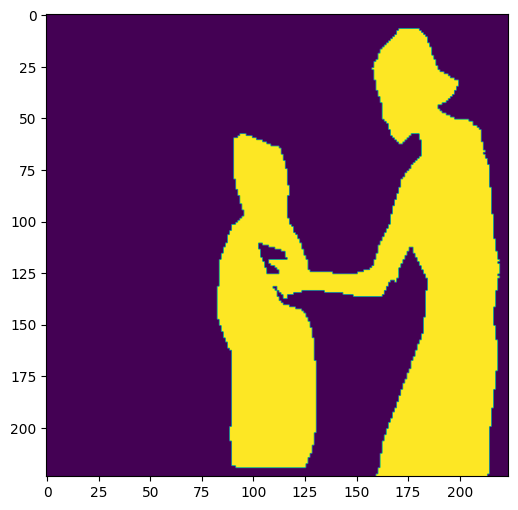

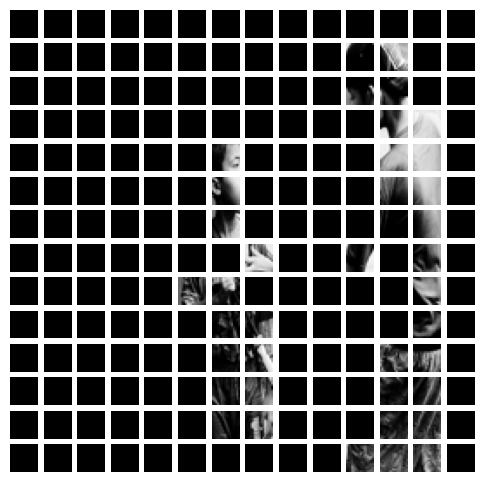

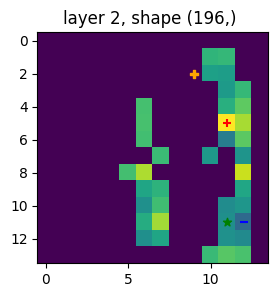

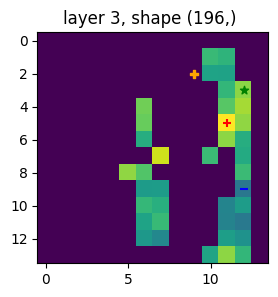

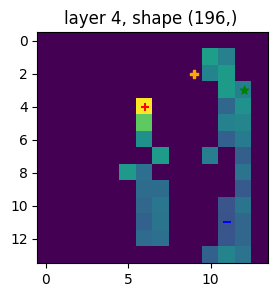

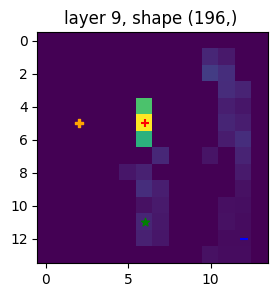

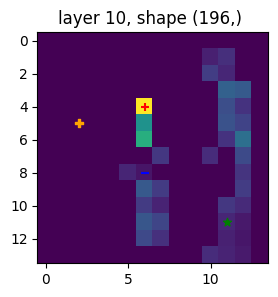

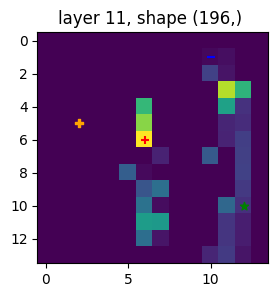

In [19]:
outputs = model.forward_pass([sample_img])
sample_attention_map = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions)).cpu().detach().numpy()[:,0,:,:]
print(sample_attention_map.shape)
sample_hidden_states = torch.stack(outputs.encoder_hidden_states).cpu().detach().numpy()
masks = get_objects_mask(sample_ann, objects=[main_obj, second_obj], option=2, attention_maps=sample_attention_map)

fg_tokens, cons_fg_token = extract_tokens(img=sample_img.resize((224,224)), 
                                          mask=np.array(masks[0].resize((224,224))),
                                          mean_att_map=sample_attention_map,
                                          layers=[2,3,4,9,10,11],
                                          debug=True)

In [24]:
fg_tokens

{2: {'max_image': 37, 'max_obj': 118, 'min_obj': 174, 'random_obj': 133},
 3: {'max_image': 37, 'max_obj': 117, 'min_obj': 175, 'random_obj': 161},
 4: {'max_image': 37, 'max_obj': 62, 'min_obj': 160, 'random_obj': 62},
 9: {'max_image': 72, 'max_obj': 76, 'min_obj': 146, 'random_obj': 147},
 10: {'max_image': 72, 'max_obj': 62, 'min_obj': 118, 'random_obj': 160},
 11: {'max_image': 72, 'max_obj': 90, 'min_obj': 118, 'random_obj': 132}}

In [25]:
fg_tokens

{2: {'max_image': 37, 'max_obj': 118, 'min_obj': 174, 'random_obj': 175},
 3: {'max_image': 37, 'max_obj': 117, 'min_obj': 175, 'random_obj': 161},
 4: {'max_image': 37, 'max_obj': 62, 'min_obj': 160, 'random_obj': 174},
 9: {'max_image': 72, 'max_obj': 76, 'min_obj': 146, 'random_obj': 160},
 10: {'max_image': 72, 'max_obj': 62, 'min_obj': 118, 'random_obj': 133},
 11: {'max_image': 72, 'max_obj': 90, 'min_obj': 118, 'random_obj': 160}}

In [25]:
# Display tokens
# plt.imshow(mean_att_map[-1,0,1:].cpu().detach().numpy().reshape(grid_size, grid_size))
# col_p = token // grid_size
# row_p = token - (col_p * grid_size)
# plt.scatter(row_p, col_p, marker='*', c='red')

# Extract tokens from datasets

In [20]:
import pandas as pd
from tqdm import tqdm

In [21]:
person_annotations['27'][0].keys()

dict_keys(['annotations', 'image'])

In [22]:
labels_map = {27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase'}
labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase']
# (1, 27) ('person', 'backpack'): 3524
# (1, 28) ('person', 'umbrella'): 2089
# (1, 31) ('person', 'handbag'): 4890
# (1, 32) ('person', 'tie'): 1543
# (1, 33) ('person', 'suitcase'): 1048
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'backpack': 0, 'umbrella': 1, 'handbag': 2, 'tie': 3, 'suitcase': 4}

In [86]:
labels_map = {27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 
              44: 'bottle', 47: 'cup', 48: 'fork', 49: 'knife', 51: 'bowl', 62: 'chair'}
labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'bottle', 'cup', 'fork', 'knife', 'bowl', 'chair']
# (67, 44) ('dining table', 'bottle'): 1060
# (67, 47) ('dining table', 'cup'): 1919
# (67, 48) ('dining table', 'fork'): 1191
# (67, 49) ('dining table', 'knife'): 1066
# (67, 51) ('dining table', 'bowl'): 1793
# (67, 62) ('dining table', 'chair'): 1898
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'backpack': 0,
 'umbrella': 1,
 'handbag': 2,
 'tie': 3,
 'suitcase': 4,
 'bottle': 5,
 'cup': 6,
 'fork': 7,
 'knife': 8,
 'bowl': 9,
 'chair': 10}

In [34]:
# annotation_groups = {67: dining_obj_annotations, 1: person_annotations}
annotation_groups = {1: person_annotations}
BATCH_SIZE = 6

In [35]:
for main_class, annotations_file in annotation_groups.items():
    for second_class, task_annotations in annotations_file.items():        
        features = {"image_id": [],
            "image_filename": [],
            "caption_filter": [], 
            "main_fg_tokens": [],
            "main_consistent_fg_token": [],
#                 "main_bg_tokens": [],
#                 "main_consistent_bg_token": [],                    
#                 "second_bg_tokens": [],
#                 "second_consistent_bg_token": [],
            "second_fg_tokens": [],
            "second_consistent_fg_token": [],
            "main_fg_tokens_act": [],
            "second_fg_tokens_act": [],
            "class": []}
        
        count_img_with_caption = 0
        count_img_no_caption  = 0
        warning_msg = True
        print(f"class ({main_class}, {second_class})")
        batch_input = []
        batch_ann = []
        for idx, ann in enumerate(tqdm(task_annotations)):
            if ann['annotations']['second_object_in_caption']:
                count_img_with_caption += 1
            else:
                count_img_no_caption += 1
            
            if count_img_no_caption >= 1000 and count_img_with_caption >= 1000:
                print("Enough images (1000 with and without caption), stopping")
                break
            
            if count_img_no_caption >= 1000 and not ann['annotations']['second_object_in_caption']:
                if warning_msg:
                    print("Reached 1000 images without caption, collecting only images WITH caption now.")
                    warning_msg = False
                continue
            elif count_img_with_caption >= 1000 and ann['annotations']['second_object_in_caption']:
                continue                
            
            img = Image.open(os.path.join(COCO_PATH, 'train2017', ann['image']['file_name'])).convert('RGB')             
            batch_input.append(img)
            batch_ann.append(ann)
            
            if len(batch_input) == BATCH_SIZE:                
                outputs = model.forward_pass(batch_input)                
                layers_act = torch.stack(outputs.encoder_hidden_states).cpu().detach().numpy()
                mean_att_map = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions), renorm_weights=True)            
                mean_att_map = mean_att_map.cpu().detach().numpy()
                
                for input_i in range(len(batch_input)):                    
                    masks = get_objects_mask(batch_ann[input_i], 
                                             objects=[int(main_class), int(second_class)], 
                                             option=4, 
                                             attention_maps=mean_att_map[:,input_i,:,:])
                    if masks is not None:
                        # MAIN OBJECT
                        main_fg_tokens, main_cons_fg_token = extract_tokens(img=img.resize((224,224)), 
                                                                            mask=np.array(masks[0][11].resize((224,224))),
                                                                            mean_att_map=mean_att_map[:,input_i,:,:],
                                                                            layers=[3,4,9,10,11],
                                                                            mask_threshold=.30) #prev .50
                        # SECOND OBJECT
                        sec_fg_tokens, sec_cons_fg_token = extract_tokens(img=img.resize((224,224)), 
                                                                          mask=np.array(masks[1][11].resize((224,224))),
                                                                          mean_att_map=mean_att_map[:,input_i,:,:],
                                                                          layers=[3,4,9,10,11],
                                                                          mask_threshold=.10) #prev .30
                        if main_fg_tokens is not None and sec_fg_tokens is not None:
                            features["image_id"].append(batch_ann[input_i]['image']['id'])
                            features["image_filename"].append(batch_ann[input_i]['image']['file_name'])
                            features["main_fg_tokens"].append(main_fg_tokens)
                            features["main_consistent_fg_token"].append(main_cons_fg_token)
                            features["second_fg_tokens"].append(sec_fg_tokens)
                            features["second_consistent_fg_token"].append(sec_cons_fg_token)
                            # skip the CLS token. Token number is from [0, 195]
#                             layers_act = [layer_act.cpu().squeeze().detach().numpy()[1:,:] for layer_act in layer_activations]
                            token_act_per_layer = {}
                            for layer, tokens in main_fg_tokens.items():
                                token_act_per_layer[layer] = {'min_obj': layers_act[layer][input_i][tokens['min_obj']],
                                                              'max_obj': layers_act[layer][input_i][tokens['max_obj']],
                                                              'random_obj': layers_act[layer][input_i][tokens['random_obj']],
                                                              'max_image': layers_act[layer][input_i][tokens['max_image']]}

                            features["main_fg_tokens_act"].append(token_act_per_layer)                    
                            token_act_per_layer = {}
                            for layer, tokens in sec_fg_tokens.items():
                                token_act_per_layer[layer] = {'min_obj': layers_act[layer][input_i][tokens['min_obj']],
                                                              'max_obj': layers_act[layer][input_i][tokens['max_obj']],
                                                              'random_obj': layers_act[layer][input_i][tokens['random_obj']],
                                                              'max_image': layers_act[layer][input_i][tokens['max_image']]}                  
                            features["second_fg_tokens_act"].append(token_act_per_layer)                    
                            features["caption_filter"].append(batch_ann[input_i]['annotations']['second_object_in_caption'])
                            features["class"].append(labels_map[int(second_class)])                    
                    else:
                        print(f"mask is None: {batch_ann[input_i]['image']['file_name']}")
                batch_input = []
                batch_ann = []
#             if not batch_input:
#                 break
#         break
        feat_pd = pd.DataFrame(features)
        if len(feat_pd) > 0:
            feat_pd.to_pickle(f"feat_token-act_attn-based_{main_class}-{second_class}-alt.pickle")
    

class (1, 27)


100%|███████████████████████████████████████████████████████████████████████████████| 3524/3524 [10:44<00:00,  5.47it/s]


Reached 1000 images without caption, collecting only images WITH caption now.
class (1, 28)


 63%|█████████████████████████████████████████████████▉                             | 1320/2089 [15:49<09:52,  1.30it/s]

Reached 1000 images without caption, collecting only images WITH caption now.


100%|███████████████████████████████████████████████████████████████████████████████| 2089/2089 [17:52<00:00,  1.95it/s]


class (1, 31)


100%|███████████████████████████████████████████████████████████████████████████████| 4890/4890 [11:05<00:00,  7.35it/s]


Reached 1000 images without caption, collecting only images WITH caption now.
class (1, 32)


 73%|█████████████████████████████████████████████████████████▍                     | 1122/1543 [10:42<03:28,  2.02it/s]

Reached 1000 images without caption, collecting only images WITH caption now.


100%|███████████████████████████████████████████████████████████████████████████████| 1543/1543 [11:06<00:00,  2.31it/s]


class (1, 33)


100%|███████████████████████████████████████████████████████████████████████████████| 1048/1048 [11:07<00:00,  1.57it/s]


4 tokens per layer
12 layers
48 features max

In [36]:
print(len(feat_pd))
feat_pd.head()

1043


,image_id,image_filename,caption_filter,main_fg_tokens,main_consistent_fg_token,second_fg_tokens,second_consistent_fg_token,main_fg_tokens_act,second_fg_tokens_act,class
0,205573,000000205573.jpg,False,"{3: {'max_image': 105, 'max_obj': 60, 'min_obj...",None,"{3: {'max_image': 105, 'max_obj': 87, 'min_obj...",None,"{3: {'min_obj': [-1.0419731, -1.4132335, -0.77...","{3: {'min_obj': [-0.48982733, 0.6176384, -1.07...",suitcase
1,560373,000000560373.jpg,True,"{3: {'max_image': 89, 'max_obj': 89, 'min_obj'...",None,"{3: {'max_image': 89, 'max_obj': 55, 'min_obj'...",None,"{3: {'min_obj': [0.3792895, 0.6205393, 0.50587...","{3: {'min_obj': [-0.2600429, 0.32829243, 1.517...",suitcase
2,161112,000000161112.jpg,False,"{3: {'max_image': 0, 'max_obj': 105, 'min_obj'...",None,"{3: {'max_image': 0, 'max_obj': 93, 'min_obj':...",None,"{3: {'min_obj': [0.6415035, -1.3555695, -0.161...","{3: {'min_obj': [0.608897, 1.3296337, -0.31782...",suitcase
3,15918,000000015918.jpg,False,"{3: {'max_image': 121, 'max_obj': 121, 'min_ob...",None,"{3: {'max_image': 121, 'max_obj': 171, 'min_ob...",None,"{3: {'min_obj': [-1.744153, 1.2516804, 0.77643...","{3: {'min_obj': [-0.072024435, -0.41673428, -0...",suitcase
4,6033,000000006033.jpg,False,"{3: {'max_image': 118, 'max_obj': 106, 'min_ob...",None,"{3: {'max_image': 118, 'max_obj': 95, 'min_obj...",None,"{3: {'min_obj': [-0.42202544, -1.420639, 0.591...","{3: {'min_obj': [0.49626648, 1.896637, 0.32127...",suitcase


### Feature dataset stats

In [38]:
# count by class and by caption_filter
files = os.listdir("features/5_class_feat_attn_based_instance_filtering_caption-alt/")
agg = pd.DataFrame()
for file in files:
    feat_pd = pd.read_pickle(os.path.join("features/5_class_feat_attn_based_instance_filtering_caption-alt/", file))
    agg = pd.concat([agg, feat_pd.groupby(["class", "caption_filter"])["class"].count()])

In [39]:
agg

,0
"(backpack, False)",989.0
"(umbrella, False)",998.0
"(umbrella, True)",536.0
"(handbag, False)",986.0
"(tie, False)",904.0
"(tie, True)",177.0
"(suitcase, False)",746.0
"(suitcase, True)",297.0


### Random check output

In [40]:
# feat_pd = pd.read_pickle("feat_token-joint-mask_1-27.pickle")

In [41]:
sample_id = random.randint(0, len(feat_pd))
print(sample_id)
sample_feat = feat_pd[feat_pd.index==sample_id]
sample_feat

1004


,image_id,image_filename,caption_filter,main_fg_tokens,main_consistent_fg_token,second_fg_tokens,second_consistent_fg_token,main_fg_tokens_act,second_fg_tokens_act,class
1004,214213,000000214213.jpg,False,"{3: {'max_image': 161, 'max_obj': 105, 'min_ob...",None,"{3: {'max_image': 161, 'max_obj': 110, 'min_ob...",None,"{3: {'min_obj': [-0.65207744, 1.7733593, 1.106...","{3: {'min_obj': [-0.16812178, -0.8133775, 0.68...",suitcase


In [42]:
main_class_id = 1
second_class_id = [k for k,v in category_id_map.items() if v==sample_feat["class"].values[0]][0]
(main_class_id, second_class_id)

(1, 33)

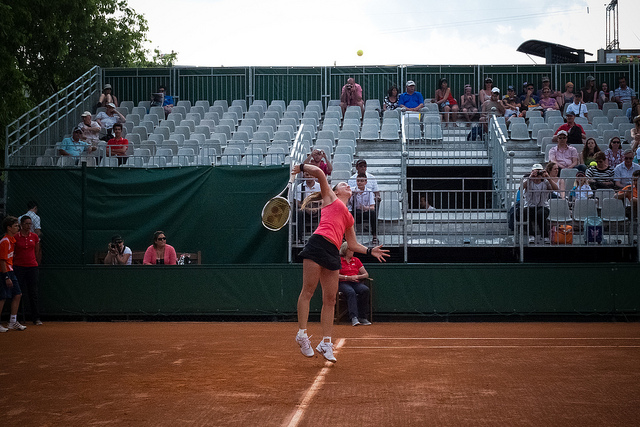

In [43]:
sample_ann = [ann for ann in person_annotations[str(second_class_id)] if ann["image"]["id"] == sample_feat["image_id"].values[0]][0]
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_feat["image_filename"].values[0])).convert("RGB")
sample_img

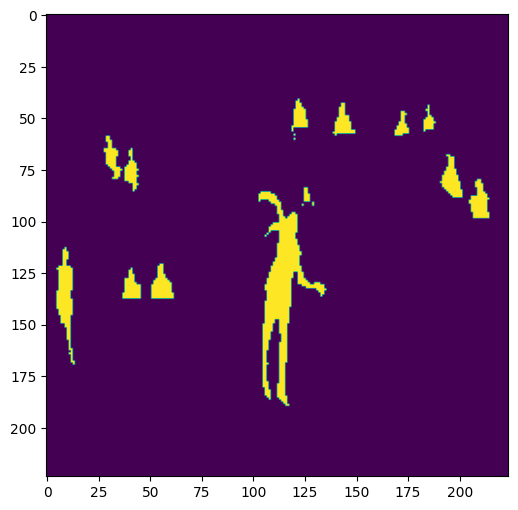

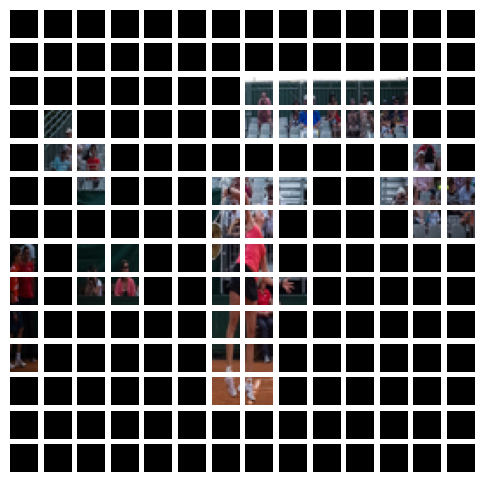

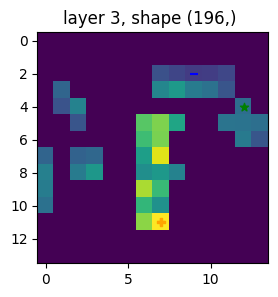

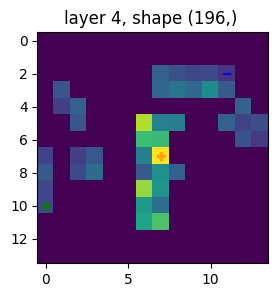

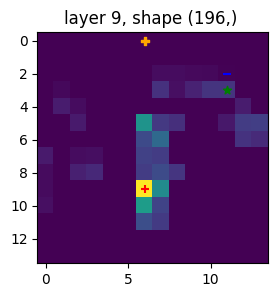

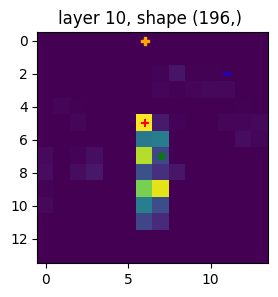

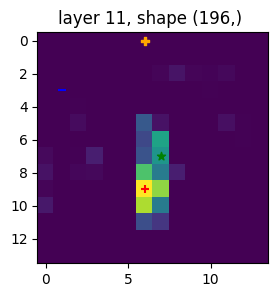

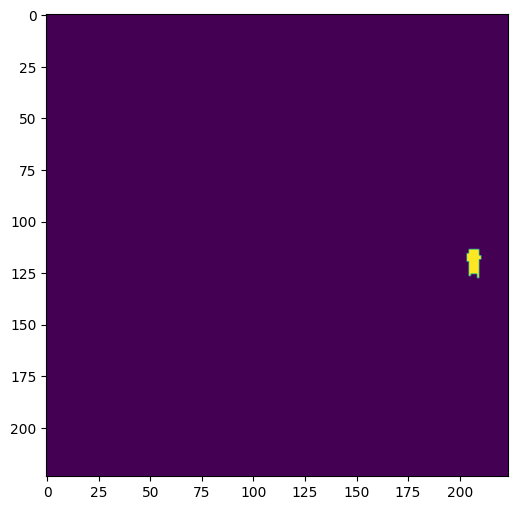

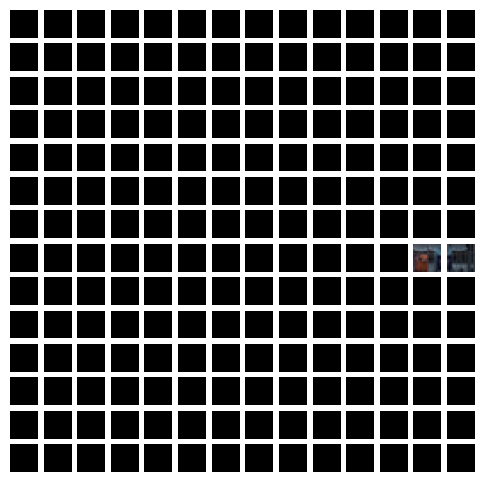

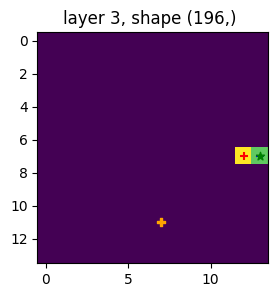

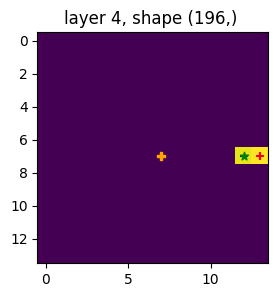

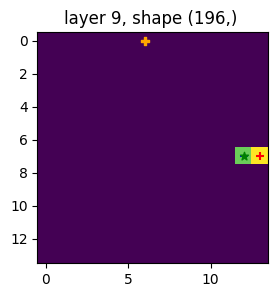

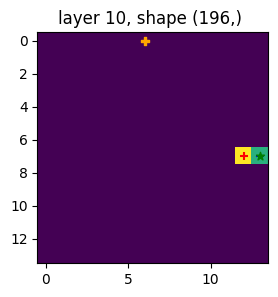

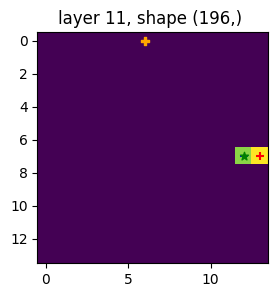

In [48]:
outputs = model.forward_pass([sample_img])
sample_attention_map = model.get_all_attention_maps(torch.stack(outputs.encoder_attentions)).cpu().detach().numpy()[:,0,:,:]
sample_hidden_states = torch.stack(outputs.encoder_hidden_states).cpu().detach().numpy()
masks = get_objects_mask(sample_ann, objects=[main_class_id, second_class_id], option=2, attention_maps=sample_attention_map)

main_fg_tokens, _ = extract_tokens(img=sample_img.resize((224,224)), 
                                          mask=np.array(masks[0].resize((224,224))),
                                          mean_att_map=sample_attention_map,
                                          layers=[3,4,9,10,11],
                                          mask_threshold=0,
                                          debug=True)

second_fg_tokens, _ = extract_tokens(img=sample_img.resize((224,224)), 
                                      mask=np.array(masks[1].resize((224,224))),
                                      mean_att_map=sample_attention_map,
                                      layers=[3,4,9,10,11],
                                      mask_threshold=0,
                                      debug=True)

In [45]:
for layer, tokens in main_fg_tokens.items():
    assert tokens["max_image"] == sample_feat["main_fg_tokens"].values[0][layer]["max_image"]
    assert tokens["max_obj"] == sample_feat["main_fg_tokens"].values[0][layer]["max_obj"]
    assert tokens["min_obj"] == sample_feat["main_fg_tokens"].values[0][layer]["min_obj"]

AssertionError: 

In [49]:
main_fg_tokens

{3: {'max_image': 161, 'max_obj': 161, 'min_obj': 37, 'random_obj': 68},
 4: {'max_image': 105, 'max_obj': 105, 'min_obj': 39, 'random_obj': 140},
 9: {'max_image': 6, 'max_obj': 132, 'min_obj': 39, 'random_obj': 53},
 10: {'max_image': 6, 'max_obj': 76, 'min_obj': 39, 'random_obj': 105},
 11: {'max_image': 6, 'max_obj': 132, 'min_obj': 43, 'random_obj': 105}}

In [47]:
sample_feat["main_fg_tokens"].values[0]

{3: {'max_image': 161, 'max_obj': 105, 'min_obj': 118, 'random_obj': 105},
 4: {'max_image': 105, 'max_obj': 105, 'min_obj': 118, 'random_obj': 119},
 9: {'max_image': 6, 'max_obj': 91, 'min_obj': 118, 'random_obj': 105},
 10: {'max_image': 6, 'max_obj': 91, 'min_obj': 119, 'random_obj': 105},
 11: {'max_image': 6, 'max_obj': 118, 'min_obj': 119, 'random_obj': 118}}

In [28]:
for layer, tokens in second_fg_tokens.items():
    assert tokens["max_image"] == sample_feat["second_fg_tokens"].values[0][layer]["max_image"]
    assert tokens["max_obj"] == sample_feat["second_fg_tokens"].values[0][layer]["max_obj"]
    assert tokens["min_obj"] == sample_feat["second_fg_tokens"].values[0][layer]["min_obj"]

AssertionError: 